In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Count, Max
from utils.tm_mgmt import *

run_id = 483

In [8]:
dts = DynamicTopic.objects.filter(run_id=run_id)

dts

<QuerySet [<DynamicTopic: {soc, stock, soil}>, <DynamicTopic: {per, thousand, part}>, <DynamicTopic: {precipit, annual, moistur}>, <DynamicTopic: {climat, chang, impact}>, <DynamicTopic: {groundwat, flow, recharg}>, <DynamicTopic: {glacier, mass, balanc}>, <DynamicTopic: {year, period, annual}>, <DynamicTopic: {cost, optim, econom}>, <DynamicTopic: {increas, decreas, effect}>, <DynamicTopic: {coral, reef, bleach}>, <DynamicTopic: {ocean, southern, marin}>, <DynamicTopic: {region, area, climat}>, <DynamicTopic: {crop, yield, wheat}>, <DynamicTopic: {atlant, north, circul}>, <DynamicTopic: {energi, renew, consumpt}>, <DynamicTopic: {delta, isotop, valu}>, <DynamicTopic: {ice, arctic, sheet}>, <DynamicTopic: {trend, station, observ}>, <DynamicTopic: {gas, coal, greenhous}>, <DynamicTopic: {warm, global, centuri}>, '...(remaining elements truncated)...']>

In [17]:
stat = RunStats.objects.get(run_id=run_id)
periods = stat.periods.all().order_by('n')
periods.values()

<QuerySet [{'title': 'AR1', 'ys': [1985, 1986, 1987, 1988, 1989, 1990], 'n': 1, 'id': 28}, {'title': 'AR2', 'ys': [1991, 1992, 1993, 1994], 'n': 2, 'id': 29}, {'title': 'AR3', 'ys': [1995, 1996, 1997, 1998, 1999, 2000], 'n': 3, 'id': 30}, {'title': 'AR4', 'ys': [2001, 2002, 2003, 2004, 2005, 2006, 2007], 'n': 4, 'id': 31}, {'title': 'AR5', 'ys': [2008, 2009, 2010, 2011, 2012, 2013], 'n': 5, 'id': 32}, {'title': 'AR6', 'ys': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2

In [191]:
alldts = DynamicTopic.objects.filter(run_id=run_id)

wg_dict = []

for p in periods:
    print(p.title)
    wgs = [
        {"WG":1, "score": 0},
        {"WG":2, "score": 0},
        {"WG":3, "score": 0}
    ]
    for topic in alldts.iterator():
        for w in wgs:
            wg = {
                "WG": w["WG"],
                "score": 0
            }
            wg['topic_id'] = topic.id
            wg['topic_title'] = topic.title
            wg['tscore'] = topic.score
            wg['period'] = p.title
            ts = dts.filter(
                topicdtopic__dynamictopic=topic,
                topicdtopic__topic__doctopic__doc__PY__in=p.ys,
                topicdtopic__topic__doctopic__doc__ipccref__wg__wg=wg["WG"],
                topicdtopic__topic__doctopic__doc__ipccref__isnull=False
            )
            if ts.count() == 0:
                wg['score'] = 0
            else:
                wg['score'] = ts.annotate(
                    topic_combination = F('topicdtopic__score') * F('topicdtopic__topic__doctopic__score')
                ).aggregate(
                    s = Sum('topic_combination')
                )['s']
            wg_dict.append(wg)
    
df = pd.DataFrame.from_dict(wg_dict)

df.head()

AR1
AR2
AR3
AR4
AR5
AR6


,WG,period,score,topic_id,topic_title
0,1,AR1,0.004763,9145,"{per, thousand, part}"
1,2,AR1,0.004042,9145,"{per, thousand, part}"
2,3,AR1,0.000351,9145,"{per, thousand, part}"
3,1,AR1,0.000023,9198,"{soc, stock, soil}"
4,2,AR1,0.000002,9198,"{soc, stock, soil}"


In [10]:

def f(x):
    t = DynamicTopic.objects.get(pk=x['topic_id'])
    return t.score
df['tscore'] = df.apply(f,axis=1)

df.head()

,Unnamed: 0,WG,period,score,topic_id,topic_title,tpsum,share,tscore
0,0,1,AR1,0.004763,9145,"{per, thousand, part}",0.009155,0.520211,194.167640
1,1,2,AR1,0.004042,9145,"{per, thousand, part}",0.009155,0.441500,194.167640
2,2,3,AR1,0.000351,9145,"{per, thousand, part}",0.009155,0.038289,194.167640
3,3,1,AR1,0.000023,9198,"{soc, stock, soil}",0.000025,0.939211,243.553848
4,4,2,AR1,0.000002,9198,"{soc, stock, soil}",0.000025,0.060789,243.553848


In [11]:
df.to_csv('dts.csv')

In [2]:
df = pd.read_csv('dts.csv')

In [3]:
df.head()

,Unnamed: 0,WG,period,score,topic_id,topic_title
0,0,1,AR1,0.004763,9145,"{per, thousand, part}"
1,1,2,AR1,0.004042,9145,"{per, thousand, part}"
2,2,3,AR1,0.000351,9145,"{per, thousand, part}"
3,3,1,AR1,0.000023,9198,"{soc, stock, soil}"
4,4,2,AR1,0.000002,9198,"{soc, stock, soil}"


In [12]:
df['tpsum'] = df['score'].groupby([df['period'],df['topic_title']]).transform('sum')
df['share'] = df['score'] / df['tpsum']
df.sort_values(['topic_title','period']).head(15)

,Unnamed: 0,WG,period,score,topic_id,topic_title,tpsum,share,tscore
141,141,1,AR1,0.000057,9213,"{adapt, capac, local}",0.000061,0.939211,419.312076
142,142,2,AR1,0.000004,9213,"{adapt, capac, local}",0.000061,0.060789,419.312076
143,143,3,AR1,0.000000,9213,"{adapt, capac, local}",0.000061,0.000000,419.312076
441,441,1,AR2,0.090213,9213,"{adapt, capac, local}",0.258641,0.348795,419.312076
442,442,2,AR2,0.137633,9213,"{adapt, capac, local}",0.258641,0.532139,419.312076
443,443,3,AR2,0.030795,9213,"{adapt, capac, local}",0.258641,0.119065,419.312076
741,741,1,AR3,0.833699,9213,"{adapt, capac, local}",2.808169,0.296884,419.312076
742,742,2,AR3,1.670778,9213,"{adapt, capac, local}",2.808169,0.594971,419.312076
743,743,3,AR3,0.303691,9213,"{adapt, capac, local}",2.808169,0.108146,419.312076
1041,1041,1,AR4,1.693531,9213,"{adapt, capac, local}",8.341584,0.203023,419.312076


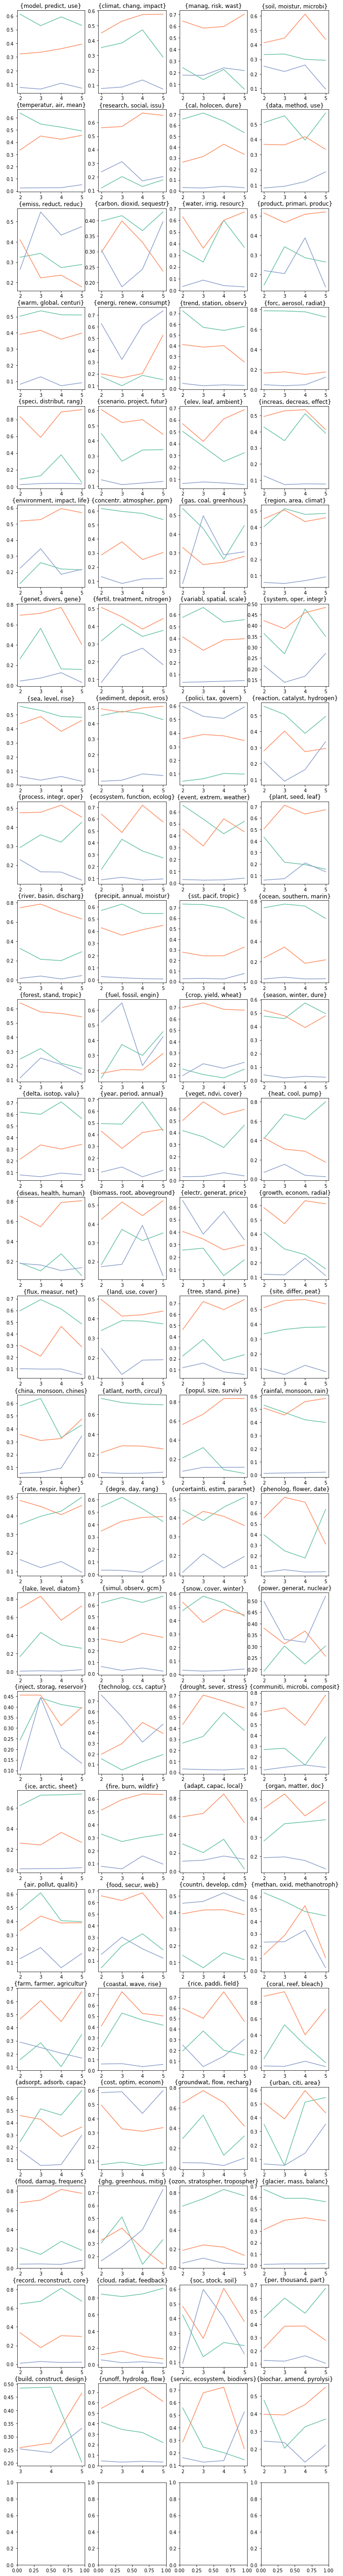

In [20]:
df = df.sort_values('tscore',ascending=False)

topics = df.topic_title.unique()

cs = 4

fig, axs = plt.subplots(len(topics)//cs+1,cs)

plt.rcParams["figure.figsize"] = [12,4*len(topics)//cs+1]

#fig, axs = plt.subplots(25,4)

for i,t in enumerate(topics):
    
    r = i // cs
    c = i % cs

    ax = axs[r][c]
    pdf = df[(df['topic_title']==t) & (df['period'] != "AR1") & (df['period'] != "AR6")].set_index('period')

    colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

    for name, group in pdf.groupby('WG'):
        x = [x+2 for x in group.index.factorize()[0]]
        ax.plot(x,group['share'], color=colors[group['WG'][0]])
        ax.set_title(t)

plt.savefig('../plots/dt_wg_changes.png',bbox_inches='tight')
plt.show()